In [1]:
import os
import shutil
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Recall,Precision
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

2021-10-04 11:32:14.055047: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-04 11:32:14.055097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
root_path = Path("../input/a-large-scale-fish-dataset/Fish_Dataset")
sub_paths = root_path.glob(r'**/*.png')
#converting to list, will deal with generator later
sub_paths = list(sub_paths)

#creating temporary list to handle generator
data = []
for i in range(len(sub_paths)):
    #get the 2nd from last directory name
    label = os.path.split(os.path.split(sub_paths[i])[0])[1]
    data.append([str(sub_paths[i]), label])
    
#Appending data to dataframe
df = pd.DataFrame(data, columns=['path', 'label'])
#Removing ground truths 
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)

In [3]:
#Splitting into training, validation, and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2, shuffle=True)
train_df.count()
test_df.count()

path     7200
label    7200
dtype: int64

path     1800
label    1800
dtype: int64

# ImageDataGenerator

In [4]:
#Importing images using image data preprocessing provided from keras
train_generator = ImageDataGenerator(validation_split=0.2)
test_generator = ImageDataGenerator()

train_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (384, 384),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)

val_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (384, 384),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "validation"
)

test_imgs = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = "path",
    y_col = "label",
    target_size = (384, 384),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


# Model Initialization

In [5]:
import sys
sys.path.append('../input/swin-transformer-tf-fixed')
from swintransformer import SwinTransformer

In [6]:
"""def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy"""

In [7]:
#strategy = auto_select_accelerator()

2021-10-04 11:32:22.839713: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-04 11:32:22.840059: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-04 11:32:22.840079: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-04 11:32:22.840103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (83937edb9888): /proc/driver/nvidia/version does not exist
2021-10-04 11:32:22.840695: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [8]:
#with strategy.scope():
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[384, 384, 3]),
    SwinTransformer('swin_large_384', num_classes=9, include_top=False, pretrained=True, use_tpu=False),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.AUC(multi_label=True), "acc"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
swin_large_384 (SwinTransfor (None, 1536)              198101556 
_________________________________________________________________
dropout_73 (Dropout)         (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                98368     
_________________________________________________________________
dropout_74 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 198,200,509
Trainable params: 195,297,469
Non-trainable params: 2,903,040
_________________________________________________________________


# Freezing Layers

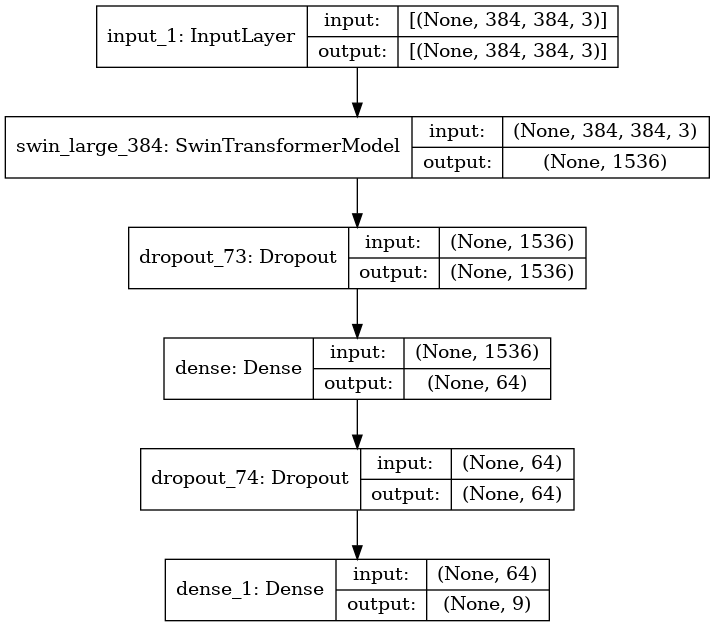

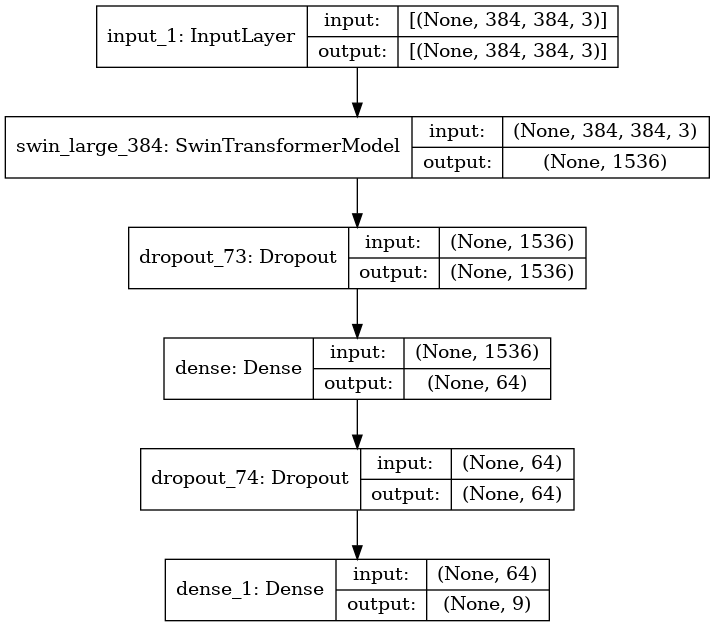

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

# Defining Callbacks

In [10]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [11]:
model_history=model.fit(train_imgs,
                        validation_data=val_imgs,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10


UnavailableError: 9 root error(s) found.
  (0) Unavailable: {{function_node __inference_train_function_111803}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1633347242.139055319","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":4143,"referenced_errors":[{"created":"@1633347242.139052939","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":398,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[tpu_compile_succeeded_assert/_17751740334726920202/_5/_321]]
  (1) Unavailable: {{function_node __inference_train_function_111803}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1633347242.139055319","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":4143,"referenced_errors":[{"created":"@1633347242.139052939","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":398,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[Cast_1/_44]]
  (2) Unavailable: {{function_node __inference_train_function_111803}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1633347242.139055319","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":4143,"referenced_errors":[{"created":"@1633347242.139052939","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":398,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[strided_slice_120/_294]]
  (3) Unavailable: {{function_node __inference_train_function_111803}} failed to connect to all addresses
Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
:{"created":"@1633347242.139055319","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":4143,"referenced_errors":[{"created":"@1633347242.139052939","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":398,"grpc_status":14}]}
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[Pad_6/paddings/_134]]
  (4) Unavailable: {{function_no ... [truncated]

In [ ]:
import keras
model.save('./best_weights.hdf5')
#model = keras.models.load_model('./best_weights.hdf5')

# Plot

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(model_history.history['precision'])
plt.plot(model_history.history['val_precision'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plt.plot(model_history.history['recall'])
plt.plot(model_history.history['val_recall'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


# Test

In [ ]:
loss, accuracy , precision,recall=model.evaluate(test_imgs)
print('Test Accuracy: %.3f' % accuracy)
print('Test Precision: %.3f' % precision)
print('Test Recall: %.3f' % recall)
print('Test loss: %.3f' % loss)


In [ ]:
y_pred = model.predict(test_imgs)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_imgs.labels,y_pred))